In [176]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
import json
%matplotlib inline

In [189]:
def plot_vec(vec, point=np.array([0,0])):
    point = np.array(point)
    vec = np.array(vec)
    projection = point+vec
    plt.plot(point[0], point[1], 'ro', label='Point')
    plt.plot(projection[0], projection[1], 'go', label='Projection')
    # Plot the vector from the point to the projection
    plt.arrow(point[0], point[1], projection[0] - point[0], projection[1] - point[1], width=0.05, color='m', label='Vector')


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
class Car():
    def __init__(self, initial_position, direction, velocity):
        self.position = np.array(initial_position)
        self._theta = direction
        self.velocity = velocity

    def set_direction(self, theta):
        self._theta = theta
    
    def get_direction(self):
        return self._theta
        
    def get_velocity_vector(self):
        return self.velocity*np.array([np.cos(self._theta), np.sin(self._theta)])
    
    def next_position(self, dt):
        return self.position + self.get_velocity_vector()*dt
    
    def update_position(self, dt):
        self.position = self.next_position(dt)
        

def plot_line(p1,p2,x_scale):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p = p2-p1
    x_min = x_scale[0]
    x_max = x_scale[1]
    x = np.linspace(x_min, x_max)
    if p1[1]-p2[1] != 0:
        m = (p1[1]-p2[1])/(p1[0]-p2[0])
        y = m*(x-p1[0])+p1[1]
        plt.plot(x,y, '--')
    else:
        y = np.ones(len(x))*p1[1]
        plt.plot(x,y, '--')

def plot_path(path):
    for t in range(len(path)-1):
        p1 = path[t]
        p2 = path[t+1]
        p = np.array([p1[0], p2[0]])
        plot_line(p1,p2,p)
        
# path = np.array([[1,0], [2,1], [4,5],[6,5]])
# plot_path(path)

def point_distance(p1, p2):
    return norm(p2-p1)

def line_point_distance(p1, p2, point):
    p = p2-p1
    n = np.array([-p[1],p[0]])
    n_hat = n/norm(n)
    return point@n_hat
    
def passed_section(p1, p2, point):
    p = p2-p1
    p3 = p2-point
    return p@p3 < 0

def distance_to_end_section(p1, p2, point):
    p = p2-p1
    p_hat = p/norm(p)
    p3 = p2-point
    return p_hat@p3


def find_next_section(path, position,current_index, threshold):
    if current_index == len(path)-2:
        return current_index
    have_passed_section = passed_section(path[current_index], path[current_index+1], position)
    if  have_passed_section:
        return current_index + 1
    if (not have_passed_section) and (distance_to_end_section(path[current_index], path[current_index+1], position) < threshold):
        return current_index + 1
    return current_index



# My algorithm

distance term using pid

In [166]:
class PID:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.last_error = 0
        self.int_error = 0


    def __call__(self, error, dt=1):
        ed = (error-self.last_error)*dt
        self.int_error += error
        self.last_error = error
        pid_value = self.kp*error + self.ki*self.int_error + self.kd*ed
        return 

    
    

0


3.4633432079864352

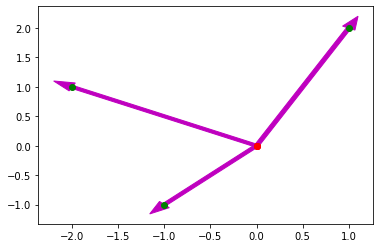

In [206]:
p = np.array([1,2])
p_hat = p/norm(p)
v = np.array([-1,-1])
if atan2(p[1], p[0]) - atan2(v[1], v[0]) < 0:
    n_hat = np.array([p[1], -p[0]])
else:
    n_hat = np.array([-p[1], p[0]])
    
plot_vec(p)
plot_vec(v)
plot_vec(n_hat)
print(n_hat@p)
atan2(p[1], p[0])
atan2(p[1], p[0]) - atan2(v[1], v[0])

## distance term using abs

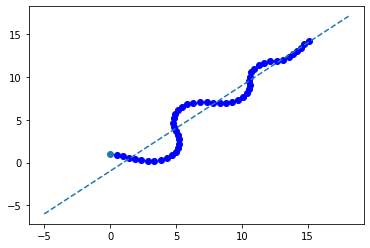

In [155]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
kd = 1
learning_rate = 0.5

#initial parameters
initial_pos = np.array([0,1])
p1 = np.array([1,0])
p2 = np.array([2,1])
p = p2-p1
n = np.array([-p[1],p[0]])
n_hat = n/norm(n)
pt = initial_pos
dt = 0.5
initial_velocity = 1
initial_theta = 0

car = Car(initial_pos, initial_theta, initial_velocity)

# positions = [initial_pos]
losses = []
plt.scatter(initial_pos[0], initial_pos[1])

for t in range(50):
    theta = car.get_direction()
    velocity = car.velocity
    v_hat = np.array([np.cos(theta), np.sin(theta)])
    v = velocity*v_hat
    p_next = car.next_position(dt)
    c = p1-p_next
    d_tilda = c@n_hat
    d = abs(d_tilda)
    ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
    new_theta = theta-learning_rate*ld_grad
    loss_d = d
    losses.append(d)
    
    car.set_direction(new_theta)
    p_next = car.next_position(dt)
    car.update_position(dt)
    plt.scatter(p_next[0], p_next[1], c='b')
    


last_position = car.position

plot_line(p1,p2,[-5,last_position[0]+3])

Text(0.5, 1.0, 'distance loss')

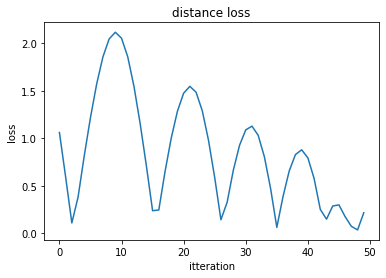

In [4]:
losses = np.array(losses)
plt.plot(losses)
plt.xlabel("itteration")
plt.ylabel("loss")
plt.title("distance loss")

## Minimizing angle

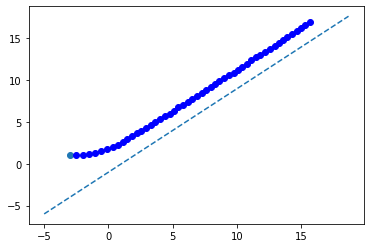

In [5]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
kd = 1
learning_rate = 0.1
w = 0.5

#initial parameters
initial_pos = np.array([-3,1])
p1 = np.array([1,0])
p2 = np.array([2,1])
p = p2-p1
n = np.array([-p[1],p[0]])
n_hat = n/norm(n)
pt = initial_pos
dt = 0.5
initial_velocity = 1
initial_theta = 0

car = Car(initial_pos, initial_theta, initial_velocity)
losses = []
# positions = [initial_pos]
plt.scatter(initial_pos[0], initial_pos[1])

for t in range(50):
    pt = car.position.copy()
    theta = car.get_direction()
    velocity = car.velocity
    v_hat = np.array([np.cos(theta), np.sin(theta)])
    v = velocity*v_hat
    p_next = car.next_position(dt)
    c = p1-p_next
    d_tilda = c@n_hat
    d = abs(d_tilda)
    
    theta_l = np.arctan(p[1]/p[0])
    theta_error_tilda = theta-theta_l
    theta_error = abs(theta_error_tilda)
    ct = p1 - pt
    distance_t_tilda = ct@n_hat
    distance_t = abs(theta_error_tilda)
    
    
    
    ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
    la_grad = np.exp(-w*distance_t)*np.sign(theta_error_tilda)
    
    loss_d = d
    loss_angle = theta_error*np.exp(-w*d)
    losses.append(loss_angle)
    
    new_theta = theta-learning_rate*la_grad
    
    car.set_direction(new_theta)
    p_next = car.next_position(dt)
    car.update_position(dt)
    plt.scatter(p_next[0], p_next[1], c='b')
    




last_position = car.position

plot_line(p1,p2,[-5,last_position[0]+3])

Text(0.5, 1.0, 'angle loss')

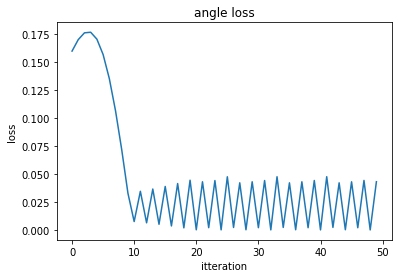

In [6]:
losses = np.array(losses)
plt.plot(losses)
plt.xlabel("itteration")
plt.ylabel("loss")
plt.title("angle loss")

## Combain the losses

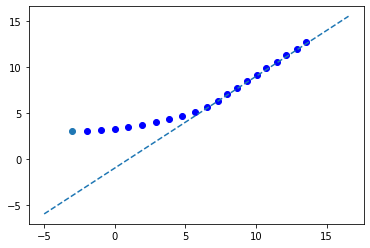

In [7]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
kd = 0.5
ka = 1
w = 1/5

learning_rate = 0.1


#initial parameters
initial_pos = np.array([0,1])
initial_pos = np.array([-3,3])
p1 = np.array([1,0])
p2 = np.array([2,1])
p = p2-p1
n = np.array([-p[1],p[0]])
n_hat = n/norm(n)
pt = initial_pos
dt = 1
initial_velocity = 1
initial_theta = 0

car = Car(initial_pos, initial_theta, initial_velocity)
losses = []
# positions = [initial_pos]
plt.scatter(initial_pos[0], initial_pos[1])

for t in range(20):
    pt = car.position.copy()
    theta = car.get_direction()
    velocity = car.velocity
    v_hat = np.array([np.cos(theta), np.sin(theta)])
    v = velocity*v_hat
    p_next = car.next_position(dt)
    c = p1-p_next
    d_tilda = c@n_hat
    d = abs(d_tilda)
    
    theta_l = np.arctan(p[1]/p[0])
    theta_error_tilda = theta-theta_l
    theta_error = abs(theta_error_tilda)
    ct = p1 - pt
    distance_t_tilda = ct@n_hat
    distance_t = abs(theta_error_tilda)
    
    
    
    ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
    la_grad = np.exp(-w*distance_t)*np.sign(theta_error_tilda)
    grad = ka*la_grad+kd*ld_grad
    
    loss_d = d
    loss_angle = theta_error*np.exp(-w*d)
    loss = ka*loss_angle+kd*loss_d
    losses.append(loss)
    
    new_theta = theta-learning_rate*grad
    
    car.set_direction(new_theta)
    p_next = car.next_position(dt)
    car.update_position(dt)
    plt.scatter(p_next[0], p_next[1], c='b')
    



last_position = car.position

plot_line(p1,p2,[-5,last_position[0]+3])

Text(0.5, 1.0, 'loss')

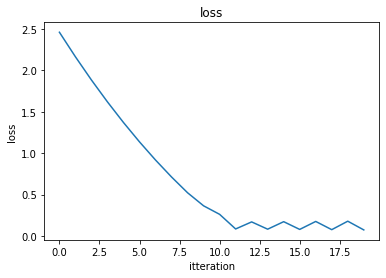

In [57]:
losses = np.array(losses)
plt.plot(losses)
plt.xlabel("itteration")
plt.ylabel("loss")
plt.title("loss")

## Now try path

In [52]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
class Car():
    def __init__(self, initial_position, direction, velocity):
        self.position = np.array(initial_position)
        self._theta = direction
        self.velocity = velocity

    def set_direction(self, theta):
        self._theta = theta
    
    def get_direction(self):
        return self._theta
        
    def get_velocity_vector(self):
        return self.velocity*np.array([np.cos(self._theta), np.sin(self._theta)])
    
    def next_position(self, dt):
        return self.position + self.get_velocity_vector()*dt
    
    def update_position(self, dt):
        self.position = self.next_position(dt)


def plot_line(p1,p2,x_scale):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p = p2-p1
    x_min = x_scale[0]
    x_max = x_scale[1]
    x = np.linspace(x_min, x_max)
    if p1[0]-p2[0] != 0:
        m = (p1[1]-p2[1])/(p1[0]-p2[0])
        y = m*(x-p1[0])+p1[1]
        plt.plot(x,y, '--')
    else:
        y = np.linspace(min(p1[1], p2[1]), max(p1[1], p2[1]))
        x = np.ones(len(y))*p1[0]
        plt.plot(x,y, '--')

def plot_path(path):
    for t in range(len(path)-1):
        p1 = path[t]
        p2 = path[t+1]
        p = np.array([p1[0], p2[0]])
        plot_line(p1,p2,p)
        
# path = np.array([[1,0], [2,1], [4,5],[6,5]])
# plot_path(path)

def point_distance(p1, p2):
    return norm(p2-p1)

def line_point_distance(p1, p2, point):
    p = p2-p1
    n = np.array([-p[1],p[0]])
    n_hat = n/norm(n)
    return point@n_hat
    
def passed_section(p1, p2, point):
    p = p2-p1
    p3 = p2-point
    return p@p3 < 0

def distance_to_end_section(p1, p2, point):
    p = p2-p1
    p_hat = p/norm(p)
    p3 = p2-point
    return p_hat@p3


def find_next_section(path, position,current_index, threshold):
    if current_index == len(path)-2:
        return current_index
    have_passed_section = passed_section(path[current_index], path[current_index+1], position)
    if  have_passed_section:
        return current_index + 1
    if (not have_passed_section) and (distance_to_end_section(path[current_index], path[current_index+1], position) < threshold):
        return current_index + 1
    return current_index



In [172]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from math import atan2
%matplotlib inline


def get_smallest_theta_error(current, refrence):
    
    if 2*np.pi+current-refrence < current-refrence:
        return 2*np.pi+current-refrence
    return current-refrence

def simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, max_itteration):
    #hyper parameters
    kd = loss_ratio
    ka = 1-loss_ratio
    print(loss_ratio, kd, ka)
    
    pt = initial_pos

    car = Car(initial_pos, initial_theta, initial_velocity)
    losses = []
    # positions = [initial_pos]
    plt.scatter(initial_pos[0], initial_pos[1])
    car_path = []

    i = 0
    for t in range(max_itteration):
        #if got to the end
        if i == len(path)-2 and passed_section(path[i], path[i+1], pt):
            break
        i = find_next_section(path, pt,i, end_section_threshold)


        p1 = path[i]
        p2 = path[i+1]
        p = p2-p1
        n = np.array([-p[1],p[0]])
        n_hat = n/norm(n)

        pt = car.position.copy()
        theta = car.get_direction()
        velocity = car.velocity




        v_hat = np.array([np.cos(theta), np.sin(theta)])
        v = velocity*v_hat
        p_next = car.next_position(dt)
        c = p1-p_next
        d_tilda = c@n_hat
        d = abs(d_tilda)
        #the angle of the line
        theta_l = atan2(p[1], p[0])        
        theta_error_tilda = theta-theta_l

            

        theta_error = abs(theta_error_tilda)
        ct = p1 - pt
        distance_t_tilda = ct@n_hat
        distance_t = abs(theta_error_tilda)



        ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
        predicted_theta = theta_l - (theta- ld_grad*learning_rate)
        if predicted_theta > (theta_l+90):
            ld_grad = -1*ld_grad
        
        
        
        la_grad = np.exp(-w*distance_t)*np.sign(theta_error_tilda)
        if theta_l < theta:
            if theta -learning_rate*ka*la_grad < theta_l:
                la_grad = theta_error_tilda/learning_rate/ka;
        if theta_l > theta:
            if theta -learning_rate*ka*la_grad > theta_l:
                la_grad = theta_error_tilda/learning_rate/ka;
        
        grad = ka*la_grad+kd*ld_grad

        loss_d = d
        loss_angle = theta_error*np.exp(-w*d)
        loss = ka*loss_angle+kd*loss_d
        losses.append(loss)
        
        new_theta = theta-learning_rate*grad
#         if i ==1:
#             print(theta_l)
#         print(ka)

        car.set_direction(new_theta)
        p_next = car.next_position(dt)
        car.update_position(dt)
        car_path.append(p_next)
#         print("loss grad",loss, grad)
    car_path = np.array(car_path)
    plt.plot(car_path[:,0], car_path[:,1],  label=f'loss ration {loss_ratio}, w {w}')
    
    plt.legend()
    




    last_position = car.position


    plot_path(path)


## path

1 1 0


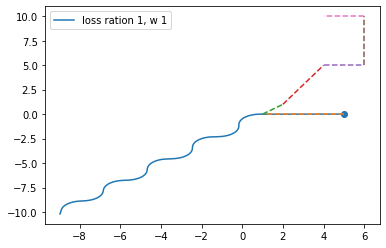

In [173]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
loss_ratio = 0.5
kd = loss_ratio
ka = 1-loss_ratio
w = 1
end_section_threshold = 0.1
initial_velocity = 0.1
dt = 0.1
learning_rate = 1

initial_pos = np.array([5,0])
#initial parameters
path = np.array([initial_pos, [1,0], [2,1], [4,5],[6,5], [6, 10], [4,10]])
loss_ratio = 1

initial_theta = np.pi

simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, 2000)

array([10.,  0.])

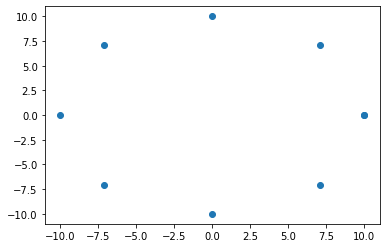

In [107]:
r = 10
theta = np.linspace(0, 2*np.pi, 9)
x = r*np.cos(theta)
y = r*np.sin(theta)
circle_path = np.array([x, y]).transpose()

plt.scatter(*zip(*circle_path))
circle_path[0]

0 0 1
0.5 0.5 0.5
1 1 0


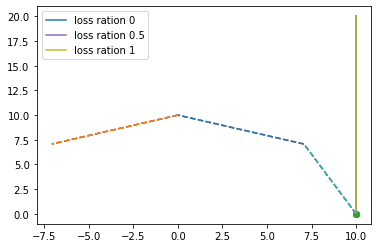

In [108]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
loss_ratio = 0
# kd = loss_ratio
# ka = 1-loss_ratio
w = 1
end_section_threshold = 0.5
initial_velocity = 1
dt = 0.1
learning_rate = 0

initial_pos = circle_path[0]
#initial parameters
path = circle_path[:4]
loss_ratio = 0.8

initial_theta = np.pi/2
for loss_ratio in [0, 0.5, 1]:
    simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, 200)

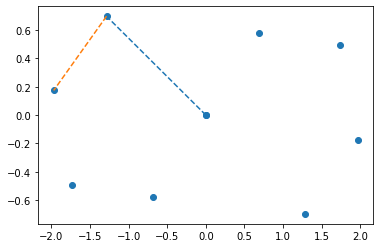

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def infinity_sign(radius):
    theta = np.linspace(-np.pi, np.pi, 10)
    x = radius * np.sin(theta)
    y = radius * np.sin(theta) * np.cos(theta) / (1 + np.sin(theta) ** 2)
    path1 = np.column_stack((x, y))
    path2 = np.column_stack((x, -y))
    return path1 #np.concatenate([path1, path2])

# Generate the infinity sign path
infinity = infinity_sign(2)
plt.scatter(*zip(*infinity))
path = infinity
path = path[:3]
plot_path(path)
# vecs = path[1:]-path[:-1]
# for point, vec in  zip(points, vecs):
#     plot_vec(point, vec)

0.8 0.8 0.19999999999999996


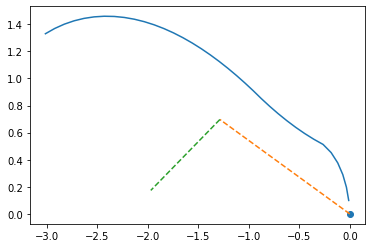

In [77]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
loss_ratio = 0.8
kd = loss_ratio
ka = 1-loss_ratio
w = 1
end_section_threshold = 1
learning_rate = 1


#initial parameters

loss_ratio = 0.8
initial_pos = np.array([0,0])
pt = initial_pos
dt = 0.1
initial_velocity = 1
initial_theta = np.pi/2
simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, 100)

# Using stanley 

In [110]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline


def simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, max_itteration):
    #hyper parameters
#     loss_ratio = 0.8
    kd = loss_ratio
    ka = 1-loss_ratio
    w = 1
#     end_section_threshold = 1
#     learning_rate = 1


    #initial parameters
#     path = np.array([initial_pos, [1,0], [2,1], [4,5],[6,5]])


#     initial_pos = np.array([0,0])
    pt = initial_pos
#     dt = 0.1
#     initial_velocity = 1
#     initial_theta = 0
    car = Car(initial_pos, initial_theta, initial_velocity)
    losses = []
    # positions = [initial_pos]
    plt.scatter(initial_pos[0], initial_pos[1])
    car_path = []

    i = 0
    for t in range(max_itteration):
        #if got to the end
        if i == len(path)-2 and passed_section(path[i], path[i+1], pt):
            break

#         i = find_next_section(path, pt,i, end_section_threshold)
        

        p1 = path[i]
        p2 = path[i+1]
        p = p2-p1
        n = np.array([-p[1],p[0]])
        n_hat = n/norm(n)
        
        

        pt = car.position.copy()
        theta = car.get_direction()
        velocity = car.velocity
        
        




        v_hat = np.array([np.cos(theta), np.sin(theta)])
        v = velocity*v_hat
        p_next = car.next_position(dt)
        c = p1-p_next
        d_tilda = c@n_hat
        d = abs(d_tilda)
        
        
        
        x_hat = np.array([1,0])
        n_angle = np.arccos(x_hat@n_hat)
        psi = n_angle-theta
        vf = velocity
        e = d
        k=1
        ks= 1
        delta = psi + np.arctan(k*e/(ks+vf))
        
        new_theta = delta
        
        
#         theta_l = np.arctan(p[1]/p[0])
#         theta_error_tilda = theta-theta_l
#         theta_error = abs(theta_error_tilda)
#         ct = p1 - pt
        
        



#         ld_grad = velocity*dt*np.sign(d_tilda)*(n_hat[0]*np.sin(theta)-n_hat[1]*np.cos(theta))
#         la_grad = np.exp(-w*distance_t)*np.sign(theta_error_tilda)
#         grad = ka*la_grad+kd*ld_grad

#         loss_d = d
#         loss_angle = theta_error*np.exp(-w*d)
#         loss = ka*loss_angle+kd*loss_d
#         losses.append(loss)

#         new_theta = theta-learning_rate*grad
        car.set_direction(new_theta)
    
        p_next = car.next_position(dt)
        car.update_position(dt)
        car_path.append(p_next)
#     print(car_path)
    car_path = np.array(car_path)
    plt.plot(car_path[:,0], car_path[:,1])
#         plt.scatter(p_next[0], p_next[1], c='b', s=0.5)




    last_position = car.position


    plot_path(path)


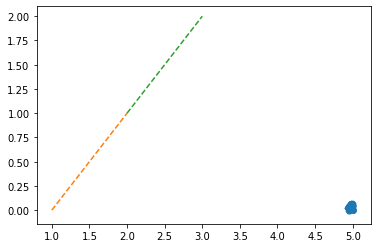

In [111]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
#hyper parameters
loss_ratio = 0.8
kd = loss_ratio
ka = 1-loss_ratio
w = 10
end_section_threshold = 0.5
initial_velocity = 1
dt = 0.1
learning_rate = w*dt*initial_velocity

initial_pos = np.array([5,0])
#initial parameters
path = np.array([[1,0], [2,1], [3,2]])

loss_ratio = 0.8

pt = initial_pos

initial_theta = 0 #np.pi/2
simulation(loss_ratio , w, end_section_threshold, learning_rate, path,initial_pos, initial_velocity, initial_theta, dt, 100)